<a id = 'home'></a>
# Spooky Author Idenficiation Modeling
---
[Kaggle Competition Home](https://www.kaggle.com/c/spooky-author-identification)

---
This notebook walks through the code I used in the NLP Kaggle compeition 'Spooky Authors'. The goal of the competition is to predict which of three authors from a similar genre and era (Edgar Allan Poe, Mary W. Shelley, and H.P. Lovecraft) is the author of a particular sentence.

For EDA, see the `Spooky Author Identification EDA` file in this repository..

<a id = 'toc'></a>
## Table of Contents

- [Project Home](#home)
- [Table of Contents](#toc)
- [Basic Library Imports](#libraries)
- [Load the Data](#data)
- [Create New Features](#features)
    - [Feature Sets](#fus)
- [Train/Test Split](#tts)
- [Establishing a Baseline](#baseline)
- [Pipeline Modeling](#pipeline)
- [Scoring and Evaluating the Model](#model-eval)
- [Expanding the Feature Set](#exp-features)
- [New Approaches to the Text Data](#tfid)
- [Neural Net for Classification](#nn)
- [Convolutional Neural Nets](#cnn)
- [Summary and Next Steps](#summary)

<a id = 'libraries'></a>
## Basic Library Imports
[Project Home](#home)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#plotting customizations
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.style.use('fivethirtyeight')
# 538 colors ['008fd5', 'fc4f30', 'e5ae38', '6d904f', '8b8b8b', '810f7c']

import sys
print("The Python version is %s.%s.%s" % sys.version_info[:3])

from sklearn.model_selection import GridSearchCV


The Python version is 3.6.1


<a id = 'data'></a>
## Load in the Data
[Project Home](#home)

In [3]:
df = pd.read_csv('train.csv')

In [4]:
print(df.shape)
df.head()

(19579, 3)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


<a id = 'features'></a>
## Feature Creation
[Project Home](#home)

### Classes for Feature Pipelines

In [5]:
# call in the pipeline functions
from sklearn.pipeline import Pipeline, FeatureUnion, make_union, make_pipeline

# call in the standard scaler and FunctionTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer

# call in libraries for class creation
from sklearn.base import BaseEstimator, TransformerMixin

# call some text libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk.tag
import string
import re

In [6]:
# create the FeatureExtractor class to make using the FeatureUnion easier for matrix objects

class SeriesFeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[self.column] 

In [7]:
# create a FeatureExtractor class for matrix objects

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column 
        
    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        return X[[self.column]]

In [8]:
# create a string cleaner class that also stems

def cleaner(text):
    stemmer = PorterStemmer()
    stop = stopwords.words('english')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.translate(str.maketrans('', '', string.digits))
    text = text.lower().strip()
    final_text = []
    for w in text.split():
        if w not in stop:
            final_text.append(stemmer.stem(w.strip()))
    return ' '.join(final_text)

#### Create text feature functions and pipelines

In [9]:
# make a function that does word counts 
def word_count(df):
    df['word_count'] = df['text'].apply(lambda x: len(re.findall(r'\w+', x))).astype(int).to_frame()
    return df

# call the function on the df to transform it
word_count(df)


# make pipeline for word count
word_count_pipe = make_pipeline(FeatureExtractor('word_count'),
                             StandardScaler()
                            )

In [10]:
# a function to return the proportion of unique words in a sentence

def unique_word_prop(df):
    split_text = df['text'].apply(lambda x: x.lower().split(' '))
    split_text = split_text.apply(lambda x: [''.join(c for c in w if c not in string.punctuation) for w in x])
    word_len = split_text.apply(lambda x: len(x))
    unique_len = split_text.apply(lambda x: len(set(x)))
    df['unique_prop'] = unique_len / word_len
    return df


# call the function on the df to transform it
unique_word_prop(df)

# make the pipeline for unique word proportion
unique_word_prop_pipe =  make_pipeline(FeatureExtractor('unique_prop'),
                                      StandardScaler()
                                      )

In [11]:
# a function to return the proportion of stopwords in a sentence

eng_stopwords = set(stopwords.words("english"))

def stopword_prop(df):
    text = df['text']
    split_text = text.apply(lambda x: x.lower().split(' '))
    split_text = split_text.apply(lambda x: [''.join(c for c in w if c not in string.punctuation) for w in x])
    split_text = split_text.apply(lambda x: [w for w in x if w])
    word_len = split_text.apply(lambda x: len(x))
    stopwords_count = split_text.apply(lambda x: len([w for w in x if w in eng_stopwords]))
    df['stopword_prop'] = (stopwords_count / word_len)
    return df

# call the function on the df to transform it
stopword_prop(df)
    
# make the pipeline for stopword proportion
stopword_prop_pipe =  make_pipeline(FeatureExtractor('stopword_prop'),
                                      StandardScaler()
                                   )

In [12]:
# a function to return the proportion of nouns in a sentence

def noun_prop(df):
    text = df['text']
    split_text = text.apply(lambda x: x.lower().split(' '))
    split_text = split_text.apply(lambda x: [''.join(c for c in w if c not in string.punctuation) for w in x])
    split_text = split_text.apply(lambda x: [w for w in x if w])
    word_len = split_text.apply(lambda x: len(x))
    pos_list = split_text.apply(lambda x: nltk.pos_tag(x))
    noun_count = pos_list.apply(lambda x: len([w for w in x if w[1] in ('NN', 'NNP', 'NNPS', 'NNS')]))
    df['noun_prop'] = (noun_count / word_len)
    return df

# call the function on the df
noun_prop(df)

# make the pipeline for noun proportion
noun_prop_pipe =  make_pipeline(FeatureExtractor('noun_prop'),
                                      StandardScaler()
                               )

In [13]:
# a function to return the proportion of adjectives in a sentence

def adj_prop(df):
    text = df['text']
    split_text = text.apply(lambda x: x.lower().split(' '))
    split_text = split_text.apply(lambda x: [''.join(c for c in w if c not in string.punctuation) for w in x])
    split_text = split_text.apply(lambda x: [w for w in x if w])
    word_len = split_text.apply(lambda x: len(x))
    pos_list = split_text.apply(lambda x: nltk.pos_tag(x))
    adj_count = pos_list.apply(lambda x: len([w for w in x if w[1] in ('JJ', 'JJR', 'JJS')]))
    df['adj_prop'] =(adj_count / word_len)
    return df

# call the function on the df
adj_prop(df)

# make the pipeline for adj proportion
adj_prop_pipe =  make_pipeline(FeatureExtractor('adj_prop'),
                               StandardScaler()
                              )

In [14]:
# a function to return the proportion of verbs in a sentence

def verb_prop(df):
    text = df['text']
    split_text = text.apply(lambda x: x.lower().split(' '))
    split_text = split_text.apply(lambda x: [''.join(c for c in w if c not in string.punctuation) for w in x])
    split_text = split_text.apply(lambda x: [w for w in x if w])
    word_len = split_text.apply(lambda x: len(x))
    pos_list = split_text.apply(lambda x: nltk.pos_tag(x))
    verb_count = pos_list.apply(lambda x: len([w for w in x if w[1] in ('VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ')]))
    df['verb_prop'] = (verb_count / word_len)
    return df

# call the function on the df
verb_prop(df)

# make the pipeline for verb proportion
verb_prop_pipe =  make_pipeline(FeatureExtractor('verb_prop'),
                                StandardScaler()
                               )

In [15]:
# functions to conduct sentiment analysis using textblob
from textblob import TextBlob

def polarity(text):
    corpus = TextBlob(text)
    return corpus.sentiment.polarity

#call the function on the data
df['polarity'] = df.text.map(lambda x: polarity(x))

# polarity pipeline
polarity_pipe = make_pipeline(FeatureExtractor('polarity'),
                             StandardScaler()
                             )

def subjectivity(text):
    corpus = TextBlob(text)
    return corpus.sentiment.subjectivity

df['subjectivity'] = df.text.map(lambda x: subjectivity(x))

# subjectivity pipeline
subjectivity_pipe = make_pipeline(FeatureExtractor('subjectivity'),
                                  StandardScaler()
                                 )

#### Create the Count Vectorizer Feature Pipeline

In [16]:
# make pipeline for count vectorizer

count_vec_pipe = make_pipeline(SeriesFeatureExtractor('text'),
                           CountVectorizer(preprocessor=cleaner))

#### Check all dataframe to confirm all the new features

In [17]:
df.head()

,id,text,author,word_count,unique_prop,stopword_prop,noun_prop,adj_prop,verb_prop,polarity,subjectivity
0,id26305,"This process, however, afforded me no means of...",EAP,41,0.853659,0.487805,0.292683,0.048780,0.146341,0.625000,0.625000
1,id17569,It never once occurred to me that the fumbling...,HPL,14,1.000000,0.571429,0.142857,0.071429,0.142857,-0.500000,0.500000
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP,36,0.888889,0.472222,0.277778,0.138889,0.111111,0.107407,0.681481
3,id27763,How lovely is spring As we looked from Windsor...,MWS,34,0.911765,0.382353,0.294118,0.176471,0.147059,0.500000,0.662500
4,id12958,"Finding nothing else, not even gold, the Super...",HPL,27,0.925926,0.407407,0.222222,0.037037,0.222222,0.200000,0.512500


<a id = 'fus'></a>
### Feature Sets

[Project Home](#home)

#### This is the simple feature union using only the sentence word count and count vectorizer

In [18]:
# create the feature union

fu = FeatureUnion([
                   ('count_vec_pipe', count_vec_pipe)
])

#### This is the more inclusive feature union making use of more text features

In [19]:
# create an expanded feature union using all the text features
fu2 = FeatureUnion([
                    ('word_count_pipe', word_count_pipe),
                    ('unique_words_pipe', unique_word_prop_pipe),
                    ('stopword_prop_pipe', stopword_prop_pipe),
                    ('noun_prop_pipe', noun_prop_pipe),
                    ('adj_prop_pipe', adj_prop_pipe),
                    ('verb_prop_pipe', verb_prop_pipe),
                    ('polarity_pipe', polarity_pipe),
                    ('subjectivity_pipe', subjectivity_pipe),
                   ('count_vec_pipe', count_vec_pipe)
])

<a id = 'tts'></a>
## Train/Test Split
[Project Home](#home)

In [20]:
from sklearn.model_selection import train_test_split

X = df.drop(['id', 'author'], axis=1)
target = df['author'].copy()

X_train, X_test, y_train, y_test = train_test_split(X,
                                    target,
                                    test_size=0.33,
                                    random_state = 8675309)

<a id = 'baseline'></a>
## Establishing the Baseline
[Project Home](#home)

In [21]:
# what is the breakdown of author percentages?
y_train.value_counts()

EAP    5238
MWS    4070
HPL    3809
Name: author, dtype: int64

#### Dominant category is EAP, what is the baseline?

In [22]:
y_train.value_counts()[0]/float(y_train.shape[0])

0.39932911488907524

In [126]:
y_test.value_counts()[0]/float(y_test.shape[0])

0.41194676570721139

<a id = 'pipeline'></a>
## Pipeline Modeling
[Project Home](#home)

In [23]:
# call in a logistic classifier inside a onevrest

from sklearn.linear_model import  LogisticRegressionCV, LogisticRegression

# create the pipeline
logit_model_pipe = Pipeline([('data', fu),
                            ('logit model', LogisticRegressionCV(cv=3))
])

In [24]:
logit_model_pipe.fit(X_train, y_train)
logit_model_pipe.score(X_train, y_train)

0.96493100556529698

Wow, that's a really good score.  Now to use the hold out data and evaluate!

<a id = 'model-eval'></a>
## Scoring the Test Data and Model Evaluation
[Project Home](#home)

### Scoring the Hold Out Dataset

In [25]:
logit_model_pipe.score(X_test, y_test)

0.80718043949241725

Okay, that seems more realistic.  Use some model evaluation to see where the model might be improved

### Model Evaluation

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

#generate predicted y values
y_pred = logit_model_pipe.predict(X_test)

#### Confusion Matrix

In [27]:
# create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# define the class names
class_names = ['EAP', 'HPL', 'MWS']

# make a data frame with meaningful column and index names
confusion = pd.DataFrame(cm,
                        index=['is_EAP','is_HPL', 'is_MWS'],
                        columns=['predict_EAP','predict_HPL', 'predict_MWS'])
# call the dataframe
confusion

,predict_EAP,predict_HPL,predict_MWS
is_EAP,2226,177,259
is_HPL,268,1420,138
is_MWS,296,108,1570


#### Classifcation Report

In [28]:
# classification report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

        EAP       0.80      0.84      0.82      2662
        HPL       0.83      0.78      0.80      1826
        MWS       0.80      0.80      0.80      1974

avg / total       0.81      0.81      0.81      6462



#### ROC Curve Plot

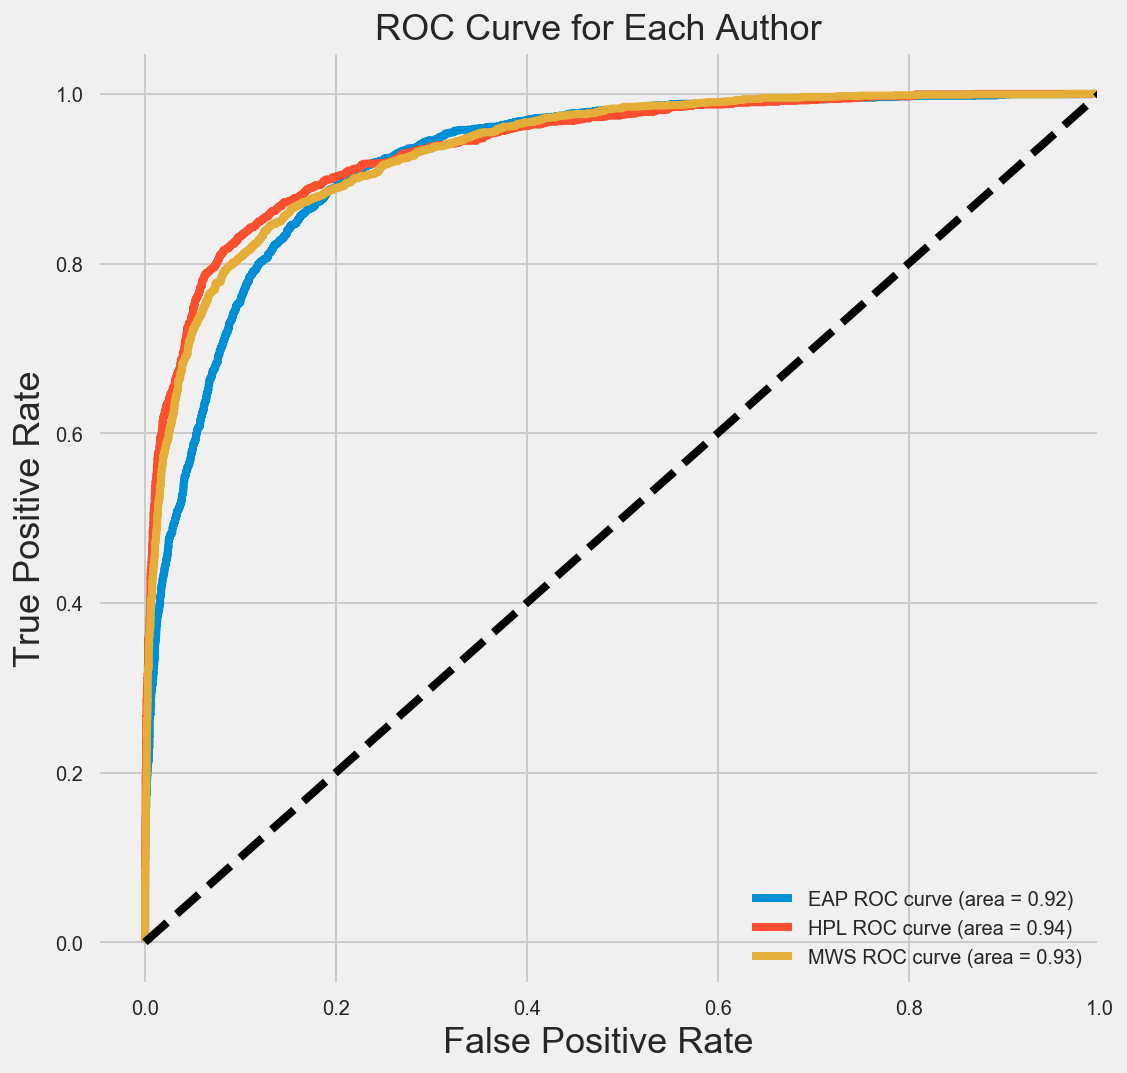

In [29]:
# roc curve
from sklearn.metrics import roc_curve, auc

# get y_score for predicted probabilities
y_predict_proba = logit_model_pipe.predict_proba(X_test)

# generate fpr, tpr, and auc for each class
fpr0, tpr0, thresh0 = roc_curve(y_test.map(lambda x: 1 if x == 'EAP' else 0), y_predict_proba[:,0])
roc_auc0 = auc(fpr0, tpr0)

fpr1, tpr1, thresh1 = roc_curve(y_test.map(lambda x: 1 if x == 'HPL' else 0), y_predict_proba[:,1])
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, thresh2 = roc_curve(y_test.map(lambda x: 1 if x == 'MWS' else 0), y_predict_proba[:,2])
roc_auc2 = auc(fpr2, tpr2)

# plot all three together, using the appropriate color for each author
plt.figure(figsize=[8,8])
plt.plot(fpr0, tpr0, label='EAP ROC curve (area = %0.2f)' % roc_auc0, linewidth=4, color = '#008fd5')
plt.plot(fpr1, tpr1, label='HPL ROC curve (area = %0.2f)' % roc_auc1, linewidth=4, color = '#fc4f30')
plt.plot(fpr2, tpr2, label='MWS ROC curve (area = %0.2f)' % roc_auc2, linewidth=4, color = '#e5ae38')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC Curve for Each Author', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<a id = 'exp-features'></a>
#  Expanding the Feature Set
[Project Home](#home)

##### Running the logit on the expanded feature set

In [68]:
# create the pipeline
logit_model_pipe2 = Pipeline([('data', fu2),
                            ('model', LogisticRegression())
])


logit_params = {
    'model__penalty': ['l2'],
    'model__C': np.logspace(-4,4,50)
}

logit_model_pipe_gs = GridSearchCV(logit_model_pipe2,
                                   param_grid = logit_params,
                                   cv =5,
                                   n_jobs=-1,
                                   verbose=1)

logit_model_pipe_gs.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 29.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 39.2min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('data', FeatureUnion(n_jobs=1,
       transformer_list=[('word_count_pipe', Pipeline(steps=[('featureextractor', FeatureExtractor(column='word_count')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('unique_words_pipe', Pipeline(steps=[('featureextractor',...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__penalty': ['l2'], 'model__C': array([  1.00000e-04,   1.45635e-04,   2.12095e-04,   3.08884e-04,
         4.49843e-04,   6.55129e-04,   9.54095e-04,   1.38950e-03,
         2.02359e-03,   2.94705e-03,   4.29193e-03,   6.25055e-03,
         9.10298e-03,   1.32571e-02,   1.93070e-0...    1.52642e+03,   2.22300e+03,   3.23746e+03,   4.71487e+03,
         6.86649e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [69]:
print('The best model params are', logit_model_pipe_gs.best_params_)
print('The best training score is: ',logit_model_pipe_gs.best_estimator_.score(X_train, y_train))
print('The test score is: ',logit_model_pipe_gs.best_estimator_.score(X_test, y_test))

The best model params are {'model__C': 1.2067926406393288, 'model__penalty': 'l2'}
The best training score is:  0.9582983914
The test score is:  0.811049210771


The exhaustive grid search running the logit model with the expanded feature set results in only a minor improvement in model performance.  The next step is to try and use a more complicated model and also potentially different nlp methods.  Before that though, we'll generate a prediction to submit to the Kaggle competition.

In [96]:
# call in the test data
df_pred = pd.read_csv("test.csv")
X_pred = df_pred.drop(['id'], axis=1)
X_pred.head()

,text
0,"Still, as I urged our leaving Ireland with suc..."
1,"If a fire wanted fanning, it could readily be ..."
2,And when they had broken down the frail door t...
3,While I was thinking how I should possibly man...
4,I am not sure to what limit his knowledge may ...


In [97]:
#perform the needed feature creations
word_count(X_pred)
unique_word_prop(X_pred)
stopword_prop(X_pred)
noun_prop(X_pred)
adj_prop(X_pred)
verb_prop(X_pred)
X_pred['polarity']=X_pred.text.map(lambda x: polarity(x))
X_pred['subjectivity']=X_pred.text.map(lambda x: subjectivity(x))

# cv = CountVectorizer(preprocessor=cleaner)
# cv.fit(X_train)
# x_preds = cv.transform(X_pred)


In [98]:
X_pred.head()

,text,word_count,unique_prop,stopword_prop,noun_prop,adj_prop,verb_prop,polarity,subjectivity
0,"Still, as I urged our leaving Ireland with suc...",19,1.000000,0.473684,0.263158,0.105263,0.210526,0.500000,0.400000
1,"If a fire wanted fanning, it could readily be ...",62,0.790323,0.548387,0.274194,0.032258,0.161290,0.100000,0.445000
2,And when they had broken down the frail door t...,33,0.878788,0.484848,0.212121,0.121212,0.151515,-0.037778,0.497778
3,While I was thinking how I should possibly man...,41,0.829268,0.512195,0.219512,0.048780,0.170732,0.002778,0.430556
4,I am not sure to what limit his knowledge may ...,11,1.000000,0.545455,0.181818,0.090909,0.272727,-0.250000,0.888889


In [102]:
# Using the grid search logit model
# generate predictions and put them in a dataframe
predictions = pd.DataFrame(logit_model_pipe_gs.predict_proba(X_pred),
                               columns = ['EAP','HPL', 'MWS'])
predictions['id'] = df_pred['id']
predictions = predictions[['id','EAP','HPL', 'MWS']]
predictions.head()
predictions.to_csv('classification_submission2.csv',index=False)

#### Result:

I placed 747/1191 with 0.50652 multiclass loss using only features of the text and no CountVectorizer

<a id = 'tfid'></a>
## New Approaches to the Text Data
[Project Home](#home)

#### Using a TfidVectorizer

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfid_pipe = make_pipeline(SeriesFeatureExtractor('text'),
                           TfidfVectorizer(preprocessor=cleaner)
                         )

In [61]:
# create an expanded feature union using all the text features
fu3 = FeatureUnion([
                    ('word_count_pipe', word_count_pipe),
                    ('unique_words_pipe', unique_word_prop_pipe),
                    ('stopword_prop_pipe', stopword_prop_pipe),
                    ('noun_prop_pipe', noun_prop_pipe),
                    ('adj_prop_pipe', adj_prop_pipe),
                    ('verb_prop_pipe', verb_prop_pipe),
                    ('polarity_pipe', polarity_pipe),
                    ('subjectivity_pipe', subjectivity_pipe),
                   ('tfid_pipe', tfid_pipe)
])

#### Using a Random Search and a Random Forest Classifier

In [71]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

rfrs_pipe = Pipeline([('data', fu3),
                     ('model', RandomForestClassifier())
                     ])

# run randomized search
# create the parameter dictionary
rfc_params = {'model__max_depth':range(1,20),
              'model__max_features':range(1,100)
#               'model__max_leaf_nodes':range(2,10),
#               'model__min_samples_leaf': range(2,10),
#               'model__min_samples_split': range(2,10)
               }

# declare the number of model iterations
n_iter_search = 50

# create the RSCV 
rfe_rs = RandomizedSearchCV(rfrs_pipe,
                                   param_distributions=rfc_params,
                                   n_iter=n_iter_search,
                                  verbose=2,
                                  n_jobs=-1,
                                  cv = 5,
                                  random_state = 8675309)

# fit the RSCV
rfe_rs.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] model__max_features=49, model__max_depth=5 ......................
[CV] model__max_features=49, model__max_depth=5 ......................
[CV] model__max_features=49, model__max_depth=5 ......................
[CV] model__max_features=49, model__max_depth=5 ......................
[CV] ....... model__max_features=49, model__max_depth=5, total=  21.6s
[CV] model__max_features=49, model__max_depth=5 ......................
[CV] ....... model__max_features=49, model__max_depth=5, total=  22.0s
[CV] ....... model__max_features=49, model__max_depth=5, total=  21.7s
[CV] model__max_features=66, model__max_depth=10 .....................
[CV] model__max_features=66, model__max_depth=10 .....................
[CV] ....... model__max_features=49, model__max_depth=5, total=  21.7s
[CV] model__max_features=66, model__max_depth=10 .....................
[CV] ...... model__max_features=66, model__max_depth=10, total=  22.9s
[CV] model__max

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  6.0min


[CV] ...... model__max_features=99, model__max_depth=18, total=  22.3s
[CV] model__max_features=50, model__max_depth=11 .....................
[CV] ...... model__max_features=99, model__max_depth=18, total=  22.4s
[CV] ...... model__max_features=50, model__max_depth=11, total=  22.2s
[CV] model__max_features=50, model__max_depth=11 .....................
[CV] model__max_features=50, model__max_depth=11 .....................
[CV] ...... model__max_features=50, model__max_depth=11, total=  22.3s
[CV] model__max_features=92, model__max_depth=14 .....................
[CV] ...... model__max_features=50, model__max_depth=11, total=  22.4s
[CV] model__max_features=92, model__max_depth=14 .....................
[CV] ...... model__max_features=50, model__max_depth=11, total=  22.5s
[CV] model__max_features=92, model__max_depth=14 .....................
[CV] ...... model__max_features=50, model__max_depth=11, total=  22.3s
[CV] model__max_features=92, model__max_depth=14 .....................
[CV] .

[CV] ...... model__max_features=85, model__max_depth=11, total=  22.6s
[CV] model__max_features=57, model__max_depth=2 ......................
[CV] ...... model__max_features=85, model__max_depth=11, total=  25.2s
[CV] model__max_features=57, model__max_depth=2 ......................
[CV] ...... model__max_features=85, model__max_depth=11, total=  24.6s
[CV] model__max_features=57, model__max_depth=2 ......................
[CV] ...... model__max_features=85, model__max_depth=11, total=  24.3s
[CV] model__max_features=57, model__max_depth=2 ......................
[CV] ....... model__max_features=57, model__max_depth=2, total=  24.2s
[CV] model__max_features=57, model__max_depth=2 ......................
[CV] ....... model__max_features=57, model__max_depth=2, total=  20.6s
[CV] model__max_features=24, model__max_depth=3 ......................
[CV] ....... model__max_features=57, model__max_depth=2, total=  20.5s
[CV] model__max_features=24, model__max_depth=3 ......................
[CV] .

[CV] ....... model__max_features=92, model__max_depth=7, total=  20.7s
[CV] model__max_features=86, model__max_depth=4 ......................
[CV] ....... model__max_features=86, model__max_depth=4, total=  20.5s
[CV] model__max_features=86, model__max_depth=4 ......................
[CV] ....... model__max_features=86, model__max_depth=4, total=  20.5s
[CV] model__max_features=65, model__max_depth=16 .....................
[CV] ....... model__max_features=86, model__max_depth=4, total=  21.0s
[CV] model__max_features=65, model__max_depth=16 .....................
[CV] ....... model__max_features=86, model__max_depth=4, total=  20.9s
[CV] model__max_features=65, model__max_depth=16 .....................


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 25.8min


[CV] ....... model__max_features=86, model__max_depth=4, total=  20.6s
[CV] model__max_features=65, model__max_depth=16 .....................
[CV] ...... model__max_features=65, model__max_depth=16, total=  20.3s
[CV] model__max_features=65, model__max_depth=16 .....................
[CV] ...... model__max_features=65, model__max_depth=16, total=  21.2s
[CV] model__max_features=9, model__max_depth=1 .......................
[CV] ...... model__max_features=65, model__max_depth=16, total=  21.3s
[CV] model__max_features=9, model__max_depth=1 .......................
[CV] ...... model__max_features=65, model__max_depth=16, total=  21.4s
[CV] model__max_features=9, model__max_depth=1 .......................
[CV] ...... model__max_features=65, model__max_depth=16, total=  21.7s
[CV] model__max_features=9, model__max_depth=1 .......................
[CV] ........ model__max_features=9, model__max_depth=1, total=  20.9s
[CV] model__max_features=9, model__max_depth=1 .......................
[CV] .

[CV] ...... model__max_features=77, model__max_depth=13, total=  18.0s
[CV] model__max_features=20, model__max_depth=16 .....................
[CV] ...... model__max_features=77, model__max_depth=13, total=  17.2s
[CV] model__max_features=20, model__max_depth=16 .....................
[CV] ...... model__max_features=77, model__max_depth=13, total=  16.7s
[CV] model__max_features=20, model__max_depth=16 .....................
[CV] ...... model__max_features=20, model__max_depth=16, total=  16.4s
[CV] model__max_features=20, model__max_depth=16 .....................
[CV] ...... model__max_features=20, model__max_depth=16, total=  17.9s
[CV] model__max_features=6, model__max_depth=7 .......................
[CV] ...... model__max_features=20, model__max_depth=16, total=  17.6s
[CV] model__max_features=6, model__max_depth=7 .......................
[CV] ...... model__max_features=20, model__max_depth=16, total=  17.6s
[CV] model__max_features=6, model__max_depth=7 .......................
[CV] .

[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 40.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=Pipeline(steps=[('data', FeatureUnion(n_jobs=1,
       transformer_list=[('word_count_pipe', Pipeline(steps=[('featureextractor', FeatureExtractor(column='word_count')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('unique_words_pipe', Pipeline(steps=[('featureextractor',...imators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
          fit_params={}, iid=True, n_iter=50, n_jobs=-1,
          param_distributions={'model__max_depth': range(1, 20), 'model__max_features': range(1, 100)},
          pre_dispatch='2*n_jobs', random_state=8675309, refit=True,
          return_train_score=True, scoring=None, verbose=2)

In [72]:
print(rfe_rs.best_score_)
print(rfe_rs.best_params_)
print(rfe_rs.best_params_)

rfe_rs_predictions = rfe_rs.best_estimator_.predict(X_test)
rfe_rs_predictions
rfe_rs.best_estimator_.score(X_test,y_test)

0.550430738736
{'model__max_features': 94, 'model__max_depth': 19}
{'model__max_features': 94, 'model__max_depth': 19}


0.55307954193748066

#### A model using only features derived from the text and no text counts with a random search and RFC

In [73]:
fu4 = FeatureUnion([
                    ('word_count_pipe', word_count_pipe),
                    ('unique_words_pipe', unique_word_prop_pipe),
                    ('stopword_prop_pipe', stopword_prop_pipe),
                    ('noun_prop_pipe', noun_prop_pipe),
                    ('adj_prop_pipe', adj_prop_pipe),
                    ('verb_prop_pipe', verb_prop_pipe),
                    ('polarity_pipe', polarity_pipe),
                    ('subjectivity_pipe', subjectivity_pipe)
])

# create the pipeline
logit_model_pipe3 = Pipeline([('data', fu4),
                            ('model', LogisticRegression())
])


logit_params = {
    'model__penalty': ['l1','l2'],
    'model__C': np.logspace(-4,4,50)
}

logit_model_pipe_gs2 = GridSearchCV(logit_model_pipe3,
                                   param_grid = logit_params,
                                   cv =5,
                                   n_jobs=-1,
                                   verbose=1)

logit_model_pipe_gs2.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   26.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(steps=[('data', FeatureUnion(n_jobs=1,
       transformer_list=[('word_count_pipe', Pipeline(steps=[('featureextractor', FeatureExtractor(column='word_count')), ('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('unique_words_pipe', Pipeline(steps=[('featureextractor',...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'model__penalty': ['l1', 'l2'], 'model__C': array([  1.00000e-04,   1.45635e-04,   2.12095e-04,   3.08884e-04,
         4.49843e-04,   6.55129e-04,   9.54095e-04,   1.38950e-03,
         2.02359e-03,   2.94705e-03,   4.29193e-03,   6.25055e-03,
         9.10298e-03,   1.32571e-02,   1.93...    1.52642e+03,   2.22300e+03,   3.23746e+03,   4.71487e+03,
         6.86649e+03,   1.00000e+04])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
    

In [74]:
print('The best model params are', logit_model_pipe_gs2.best_params_)
print('The best training score is: ',logit_model_pipe_gs2.best_estimator_.score(X_train, y_train))
print('The test score is: ',logit_model_pipe_gs2.best_estimator_.score(X_test, y_test))

The best model params are {'model__C': 0.39069399370546132, 'model__penalty': 'l1'}
The best training score is:  0.432415948769
The test score is:  0.446920458063


#### Okay, that didn't help either.  Time to investigate a different modeling approach

<a id = 'nn'></a>
## Using a Neural Net for Author Classification
[Project Home](#home)

In [112]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPool1D
from sklearn.preprocessing import LabelBinarizer

# needed for using keras inside a GridSearchCV and pipeline
from keras.wrappers.scikit_learn import KerasClassifier

# set up the data to use in the network
X_nn = df['text'].copy()
y_nn = df['author'].copy()

# T/T split
X_nn_train, X_nn_test, y_nn_train, y_nn_test = train_test_split(X_nn,y_nn,
                                                               test_size = .33,
                                                               random_state=8675309)
# instantiate the transformations
count_vec = CountVectorizer(preprocessor=cleaner)
lb = LabelBinarizer()

# transform the data
X_nn_train = count_vec.fit_transform(X_nn_train)
X_nn_test =  count_vec.transform(X_nn_test)
y_nn_train = lb.fit_transform(y_nn_train)
y_nn_test = lb.transform(y_nn_test)
print(X_nn_train.shape)
print(y_nn_train.shape)
print(X_nn_test.shape)
print(y_nn_test.shape)

(13117, 13611)
(13117, 3)
(6462, 13611)
(6462, 3)


In [63]:
def model_func(input_dim = X_nn_train.shape[1],
               layer_one_neurons = X_nn_train.shape[1],
               layer_two_neurons = 500,
               layer_three_neurons = 250,
               layer_four_neurons = 100,
               layer_five_neurons = 15):
    
    # instantiate the model
    model = Sequential()
    
    # create an input layer
    model.add(Dense(layer_one_neurons,
                   input_dim = input_dim,
                   activation = 'relu'))
    
    # create a dropout layer
    model.add(Dropout(.33))
    
    # create a hidden layer
    model.add(Dense(layer_two_neurons,
                   activation = 'relu'))
    
    # create a hidden layer
    model.add(Dense(layer_three_neurons,
                   activation = 'relu'))
    
    # create a dropout layer
    model.add(Dropout(.33))
    
    # create a hidden layer
    model.add(Dense(layer_four_neurons,
                   activation = 'relu'))
    
    # create a dropout layer
    model.add(Dropout(.33))
    
    # create a hidden layer
    model.add(Dense(layer_five_neurons,
                   activation = 'relu'))
    
    # create the output layer
    # categorical classifier so neuron is # of columns in y
    model.add(Dense(y_nn_train.shape[1], activation='softmax'))
    
    # compile
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = 'adam',
                 metrics = ['accuracy'])
    
    #return the model created
    return model

# ------------------------------------------------
# set up the grid search

# the model
ff_model = KerasClassifier(build_fn = model_func,
                           input_dim = X_nn_train.shape[1],
                          verbose = 1)
# pipe = Pipeline([
#                 ('densify', DenseTransformer()),
#                  ('model',KerasClassifier(build_fn = model_func,
#                            input_dim = X_nn_train.shape[1],
#                           verbose = 1))
#                 ])

# params = {
#     'epochs': [10],
#     'batch_size': [200],
#     'layer_one_neurons': [5000],
#     'layer_two_neurons': [1500],
#     'layer_three_neurons': [250],
#     'layer_four_neurons': [50],
#     'layer_five_neurons': [10]
# }

# gs = GridSearchCV(ff_model,
#                  param_grid = params)

Train on 13117 samples, validate on 6462 samples
Epoch 1/10
13117/13117 [==============================] - 576s 44ms/step - loss: 0.7140 - acc: 0.6781 - val_loss: 0.5049 - val_acc: 0.7962
Epoch 2/10
13117/13117 [==============================] - 566s 43ms/step - loss: 0.2346 - acc: 0.9164 - val_loss: 0.5234 - val_acc: 0.8076
Epoch 3/10
13117/13117 [==============================] - 617s 47ms/step - loss: 0.0719 - acc: 0.9759 - val_loss: 0.7158 - val_acc: 0.7988
Epoch 4/10
13117/13117 [==============================] - 652s 50ms/step - loss: 0.0221 - acc: 0.9934 - val_loss: 1.0623 - val_acc: 0.8015
Epoch 5/10
13117/13117 [==============================] - 682s 52ms/step - loss: 0.0125 - acc: 0.9961 - val_loss: 1.2945 - val_acc: 0.7934
Epoch 6/10
13117/13117 [==============================] - 669s 51ms/step - loss: 0.0086 - acc: 0.9976 - val_loss: 1.4164 - val_acc: 0.8002
Epoch 7/10
13117/13117 [==============================] - 598s 46ms/step - loss: 0.0056 - acc: 0.9979 - val_loss: 1.4

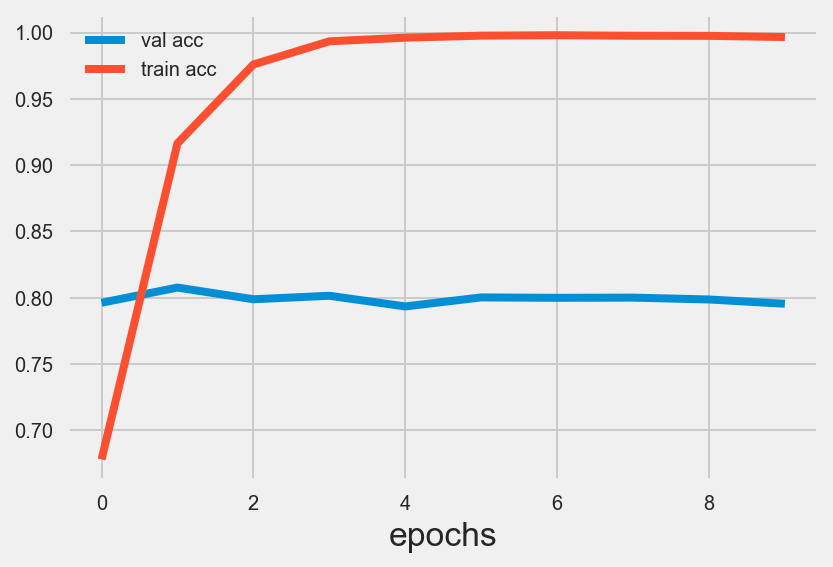

In [64]:
history = ff_model.fit(X_nn_train.todense(), y_nn_train,
         validation_data = (X_nn_test.todense(), y_nn_test),
         epochs = 10,
          batch_size = 200)
plt.plot(history.history['val_acc'], label='val acc')
plt.plot(history.history['acc'], label='train acc')
plt.xlabel('epochs')
plt.legend();

In [65]:
#ff_model.predict(X_nn_test.todense())
ff_model.score(X_nn_test.todense(), y_nn_test)

6462/6462 [==============================] - 84s 13ms/step


0.79541937486190462

<a id = 'cnn'></a>
## Convolutional Neural Nets
[Project Home](#home)

Train on 13117 samples, validate on 6462 samples
Epoch 1/10
13117/13117 [==============================] - 469s 36ms/step - loss: 1.0903 - acc: 0.3955 - val_loss: 1.0851 - val_acc: 0.4119
Epoch 2/10
13117/13117 [==============================] - 467s 36ms/step - loss: 1.0897 - acc: 0.3993 - val_loss: 1.0849 - val_acc: 0.4119
Epoch 3/10
13117/13117 [==============================] - 611s 47ms/step - loss: 1.0893 - acc: 0.3993 - val_loss: 1.0850 - val_acc: 0.4119
Epoch 4/10
13117/13117 [==============================] - 709s 54ms/step - loss: 1.0893 - acc: 0.3993 - val_loss: 1.0846 - val_acc: 0.4119
Epoch 5/10
13117/13117 [==============================] - 464s 35ms/step - loss: 1.0893 - acc: 0.3993 - val_loss: 1.0848 - val_acc: 0.4119
Epoch 6/10
13117/13117 [==============================] - 463s 35ms/step - loss: 1.0890 - acc: 0.3993 - val_loss: 1.0846 - val_acc: 0.4119
Epoch 7/10
13117/13117 [==============================] - 463s 35ms/step - loss: 1.0892 - acc: 0.3993 - val_loss: 1.0

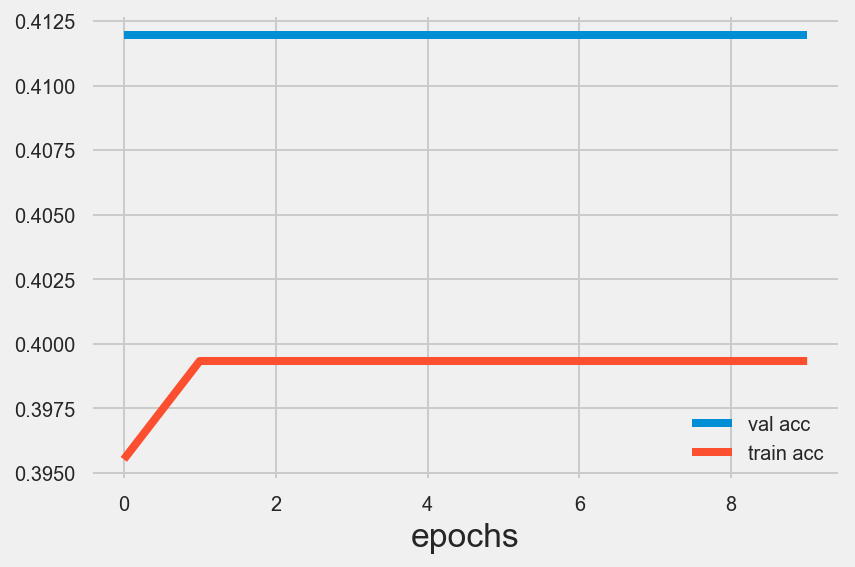

In [124]:
from keras.layers import GlobalAveragePooling1D

input_dim = X_nn_train.shape[1]
embedding_dims = 200

def create_model(embedding_dims=200,
                 optimizer='adam'):
    
    model = Sequential()
    
    model.add(Embedding(input_dim=input_dim,
                        output_dim=embedding_dims))
    
    model.add(GlobalAveragePooling1D())
    
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    
    return model


model = create_model()
history = model.fit(X_nn_train.todense(), y_nn_train,
                 batch_size=100,
                 validation_data=(X_nn_test.todense(), y_nn_test),
                 epochs=10)
plt.plot(history.history['val_acc'], label='val acc')
plt.plot(history.history['acc'], label='train acc')
plt.xlabel('epochs')
plt.legend();

<a id = 'summary'></a>
## Summary and Next Steps
[Project Home](#home)

Despite investigsting the use of more advanced modeling techniques, the logisitc regression with an expanded feature set remains my most accurate model.  I submitted this model to Kaggle.  A comparison of the model performance can be seen in the creation of the figure below.  Despite the closing of the competition, I still indend to return to this project and try and improve my score.  Several possible avenues exist to do so, generally falling into one of two categories.  The first category is on the data side.  I can try and engineer more features from the data to distinguish authors, particularly punctuation usage.  For example, instead of all punctuation (as I currently do), I could focus on comma usage.  Another possiblity is to make better use of some of the Count Vectorizer hyperparamaters such as n-grams.  Yet another option is to employ the Word2vec library for a slightly different approach to the NLP.  The second category is on the modeling side.  I could investigate building a different convolutional neural net.  I could also look into using a stacked model approach to avoid some of the overfitting that is currently hampering my model.

Overall, I am pleased with the progress of my project and the performance of my model.  I have also identified the ways in which I might move forward to continue to improve my model when I choose to return to this project in the future.

        names  train   test
0    Baseline  0.399  0.412
1  Base Logit  0.965  0.807
2  Full Logit  0.958  0.811
3         RFC  0.550  0.553
4  Neural Net  0.997  0.795
5         CNN  0.399  0.412


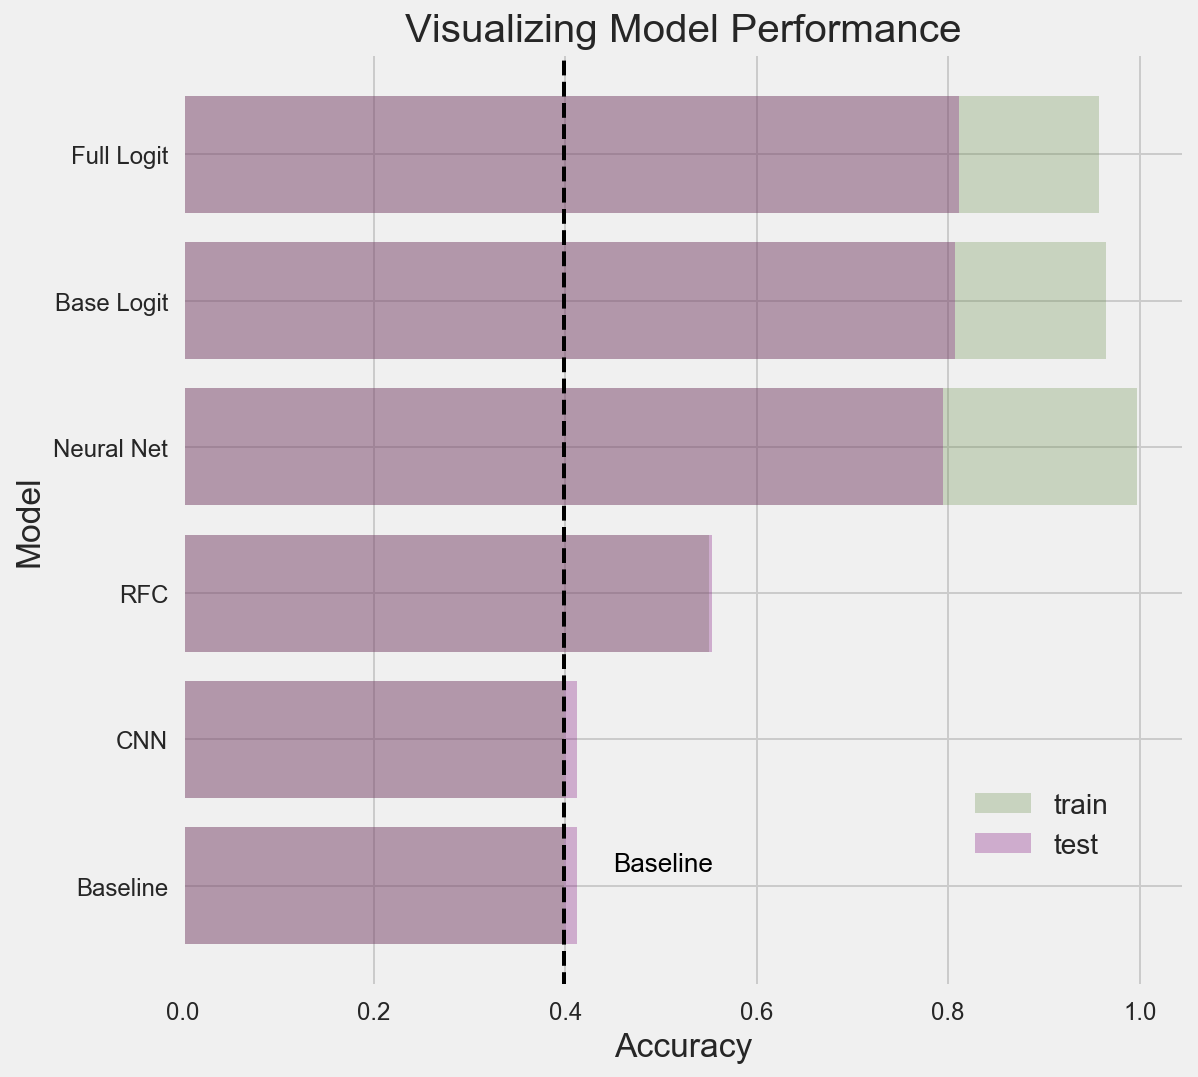

In [157]:
names = ['Baseline',
        'Base Logit',
        'Full Logit',
        'RFC',
        'Neural Net',
        'CNN']
train = [0.399,
         0.965,
         0.958,
         0.550,
         0.997,
         0.399]
test = [0.412,
       0.807,
       0.811,
       0.553,
       0.795,
       0.412]

accuracy_dct = dict(zip(names, train))

accuracy_df = pd.DataFrame(list(accuracy_dct.items()), columns = ['names','train'])
accuracy_df['test'] = test
print(accuracy_df)

# plot as bar chart

names = accuracy_df['names']

# sort importances
indices = np.argsort(accuracy_df['test'])

# plot as bar chart
fig = plt.figure(figsize=(8, 8))
plt.barh(np.arange(len(names)), accuracy_df['train'][indices], alpha = .3,color = '#6d904f', label = 'train')
plt.barh(np.arange(len(names)), accuracy_df['test'][indices], alpha = .3, color = '#810f7c', label = 'test')
plt.yticks(np.arange(len(names)), np.array(names)[indices], size=12)
plt.xticks(size=12)
_ = plt.ylabel('Model')
_ = plt.xlabel('Accuracy')
_ = plt.title('Visualizing Model Performance')
plt.axvline(x=0.399, color='black', linestyle='--', lw=2)
plt.text(0.45, 0.1, 'Baseline',
        color='black', fontsize=13)
plt.legend(loc=(.78, .125), fontsize=14)